In [1]:
# Libraries

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning) 

import csv_to_sqlite 
import sqlite3
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import statsmodels.formula.api as smf
import os 


 # visualizing pipelines in HTML
from sklearn import set_config; set_config(display='diagram')

pd.set_option('display.max_columns', None)

## Data preparation

In [2]:
# Load data
df = pd.read_csv('../raw_data/listings.csv')

# No needed columns
columns_todrop = ['id',
                  'listing_url',
                  'scrape_id',
                  'name',
                  'description',
                  'neighborhood_overview',
                  'picture_url',
                  'host_id',
                  'host_url',
                  'host_name',
                  'host_location',
                  'host_about',
                  'host_thumbnail_url',
                  'host_picture_url',
                  'host_verifications',
                  'neighbourhood',
                  'neighbourhood_group_cleansed',
                  'calendar_last_scraped',
                  'bathrooms',
                  'calendar_updated',
                  'license',
                  'host_response_time',
                  'host_response_rate',
                  'host_acceptance_rate',
                  'bathrooms_text',
                  'host_neighbourhood',
                  'last_review'
                 ]
df = df.drop(columns=columns_todrop)

# Converting Amenities from str to list
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))
df['total_amenities'] = df['amenities'].apply(lambda x: len(x))

# Droping null - subset: host since 
df.dropna(subset=['host_since'],inplace=True)

# Formating to datetime
df[['host_since','first_review','last_scraped']] = df[['host_since','first_review','last_scraped']].apply(pd.to_datetime)

# Calculating Host Tenure
df['host_tenure'] = (df['last_scraped'] - df['host_since']).dt.days

# Formating Price
df['price'] = df['price'].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)

# Reseting Index
df.reset_index(drop=True,inplace=True)


## Basic Model

In [3]:
# Set of columns for a basic model

reg_columns = [
    'latitude',
    'longitude',
    'room_type',
    'accommodates',
    'bedrooms',
    'beds',
    'minimum_nights',
    'neighbourhood_cleansed',
    'price'
    
]
df_reg = df[reg_columns]
df_reg = df_reg[df_reg['price']>0]
df_reg.head(5)

,latitude,longitude,room_type,accommodates,bedrooms,beds,minimum_nights,neighbourhood_cleansed,price
0,51.56861,-0.11270,Private room,2,1.0,NaN,1,Islington,65.0
1,51.48780,-0.16813,Entire home/apt,2,1.0,1.0,3,Kensington and Chelsea,75.0
2,51.52195,-0.14094,Entire home/apt,6,3.0,3.0,4,Westminster,265.0
3,51.47935,-0.19743,Private room,2,1.0,1.0,3,Hammersmith and Fulham,150.0
4,51.57438,-0.21081,Private room,2,1.0,NaN,10,Barnet,29.0


In [4]:
# Total percent Nulls values
df_reg.isnull().sum()/len(df_reg)*100

latitude                  0.000000
longitude                 0.000000
room_type                 0.000000
accommodates              0.000000
bedrooms                  5.997506
beds                      5.440123
minimum_nights            0.000000
neighbourhood_cleansed    0.000000
price                     0.000000
dtype: float64

### Basic Model Pipeline

In [5]:
X = df_reg.drop(columns='price')
y = df_reg['price']

# Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Pipeline 
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer([
    ('encoding', cat_transformer, ['room_type','neighbourhood_cleansed']),
    ('imputer', KNNImputer(missing_values=np.nan),['bedrooms','beds'])],
    remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model',LinearRegression())
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['room_type',
                                                   'neighbourhood_cleansed']),
                                                 ('imputer', KNNImputer(),
                                                  ['bedrooms', 'beds'])])),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

### Basic Model Scoring

In [6]:
# Fit
pipe.fit(X_train,y_train)
# Predict
y_pred = pipe.predict(X_train)

print('Scoring with Train data')
print(f'R2 Score: {pipe.score(X_train,y_train)}')
print(f'RMSE: {mean_squared_error(y_train, y_pred,squared=False)}')
print(f'MAE: {mean_absolute_error(y_train, y_pred)}')

Scoring with Train data
R2 Score: 0.06910708301656732
RMSE: 332.2833339161668
MAE: 89.55553595315509


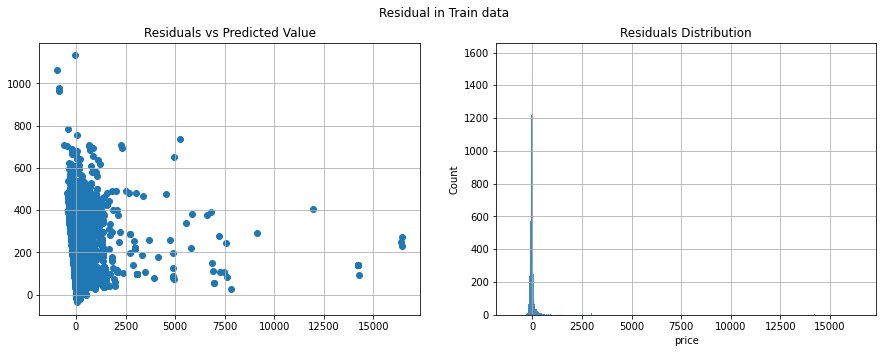

In [7]:
# Residual Evaluation Train
residuals = y_train - y_pred

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(residuals,y_pred)
plt.title('Residuals vs Predicted Value')
plt.grid()

plt.subplot(122)
sns.histplot(residuals)
plt.title('Residuals Distribution')
plt.grid()

plt.suptitle('Residual in Train data')
plt.show()

In [8]:
# Predict in Test set
y_pred = pipe.predict(X_test)
print('Scoring with Test data')

print(f'R2 Score: {pipe.score(X_test,y_test)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred,squared=False)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

Scoring with Test data
R2 Score: 0.07301275612656466
RMSE: 349.5300160745963
MAE: 92.90663190831062


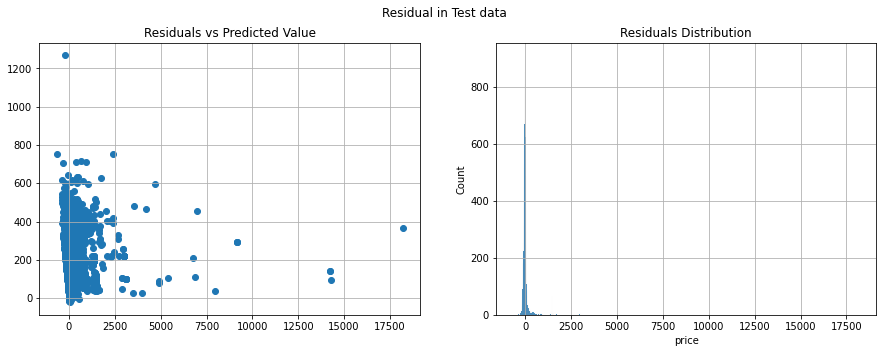

In [9]:
# Residuals Evaluation Test

residuals = y_test - y_pred

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(residuals,y_pred)
plt.title('Residuals vs Predicted Value')
plt.grid()

plt.subplot(122)
sns.histplot(residuals)
plt.title('Residuals Distribution')
plt.suptitle('Residual in Test data')
plt.grid()
plt.show()

### Basic Model pickle file

In [10]:
import pickle

# Export pipeline as pickle file
with open("pipeline.pkl", "wb") as file:
    pickle.dump(pipe, file )

## Model Tuning Exploration 

### Correlations with Price

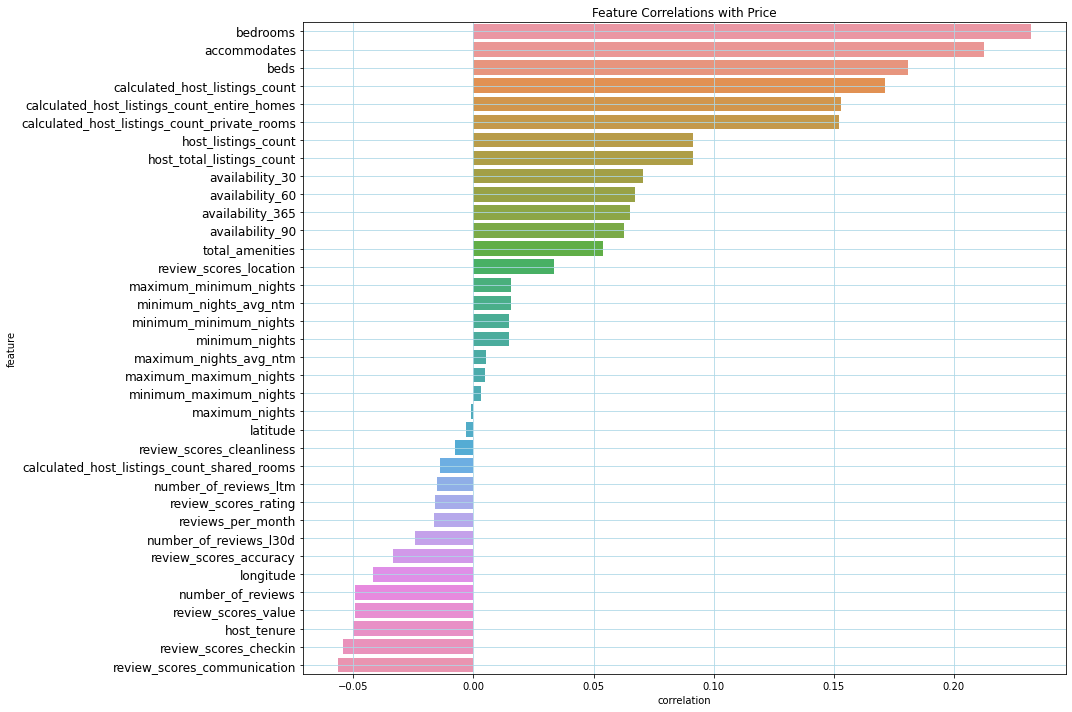

In [11]:
or_corr = pd.DataFrame(df.corrwith(df['price']).sort_values(ascending=False)).reset_index()
or_corr.columns = ['feature', 'correlation'] # rename columns
or_corr.drop(or_corr[or_corr['feature']=='price'].index,inplace=True)

plt.figure(figsize=(15,10))
sns.barplot(data=or_corr,x='correlation',y='feature')
plt.title('Feature Correlations with Price', size=12)
plt.yticks(size=12)
plt.grid(color='lightblue')
plt.tight_layout()
plt.show()

### Model with Feature encoding

In [12]:
reg_columns = [
    'latitude',
    'longitude',
    'room_type',
    'accommodates',
    'bedrooms',
    'beds',
    'minimum_nights',
    'neighbourhood_cleansed',
    'price'
    
]
df_reg = df[reg_columns].copy()

# Imputing Bedrooms and Beds
imputer_bedroom = KNNImputer(missing_values=np.nan)
imputer_bed = KNNImputer(missing_values=np.nan)

df_reg['bedrooms'] = imputer_bedroom.fit_transform(df[['bedrooms']])
df_reg['beds'] = imputer_bed.fit_transform(df[['beds']])

# Feature Encoding
# ------------------------------------------------------

# Room Type
encoder_room_type = OneHotEncoder(sparse=False)
room_type_encoded = pd.DataFrame(encoder_room_type.fit_transform(df_reg[['room_type']]))
room_type_encoded.columns=[x.replace(' ','_').replace('/','_') for x in encoder_room_type.categories_[0].tolist()]

# Neighbourhood
encoder_neighbourhood = OneHotEncoder(sparse=False)
neighbourhood_encoded = pd.DataFrame(encoder_neighbourhood.fit_transform(df_reg[['neighbourhood_cleansed']]))
neighbourhood_encoded.columns=[x.replace(' ','_') for x in encoder_neighbourhood.categories_[0].tolist()]

# Concatenating encoded dataframes 
df_reg = pd.concat([df_reg, room_type_encoded, neighbourhood_encoded], axis=1)
df_reg.drop(columns=['room_type','neighbourhood_cleansed'], inplace=True)

# drop price=0
df_reg = df_reg[df_reg['price']>0]

df_reg.head(5)

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,price,Entire_home_apt,Hotel_room,Private_room,Shared_room,Barking_and_Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City_of_London,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith_and_Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington_and_Chelsea,Kingston_upon_Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond_upon_Thames,Southwark,Sutton,Tower_Hamlets,Waltham_Forest,Wandsworth,Westminster
0,51.56861,-0.11270,2,1.0,1.758031,1,65.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,51.48780,-0.16813,2,1.0,1.000000,3,75.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,51.52195,-0.14094,6,3.0,3.000000,4,265.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,51.47935,-0.19743,2,1.0,1.000000,3,150.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,51.57438,-0.21081,2,1.0,1.758031,10,29.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Correlations with Encoded Features

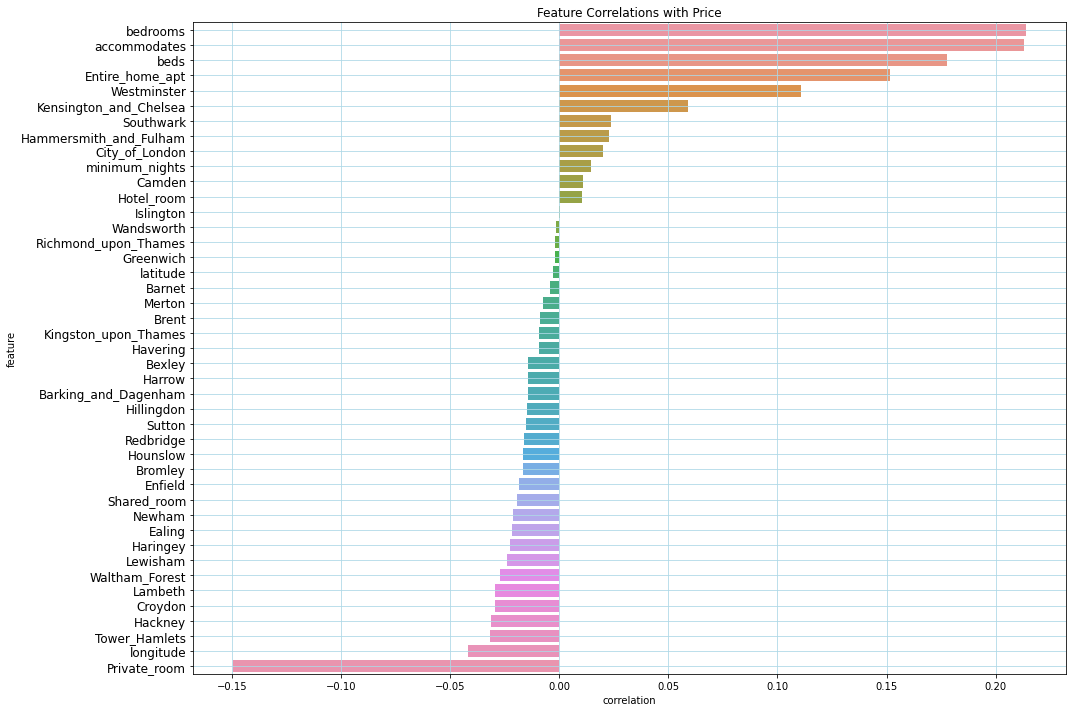

In [13]:
or_corr = pd.DataFrame(df_reg.corrwith(df_reg['price']).sort_values(ascending=False)).reset_index()
or_corr.columns = ['feature', 'correlation'] # rename columns
or_corr.drop(or_corr[or_corr['feature']=='price'].index,inplace=True)

plt.figure(figsize=(15,10))
sns.barplot(data=or_corr,x='correlation',y='feature')
plt.title('Feature Correlations with Price', size=12)
plt.yticks(size=12)
plt.grid(color='lightblue')
plt.tight_layout()
plt.show()

#### Linear Model OSL

In [14]:
def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

In [15]:
model = smf.ols(formula = formula_from_cols(df_reg,'price'), data=df_reg).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     126.1
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        19:44:04   Log-Likelihood:            -4.8188e+05
No. Observations:               66561   AIC:                         9.639e+05
Df Residuals:                   66519   BIC:                         9.642e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -5225.8465   3528.470     -1.481      0.139   -1.21e+04    1689.953
latitude                 129.9652     87.724      1.482      0.138     -41.974     301.904
longitude                 54.0420     54.095      0.999      0.318     -51.984     160.068
accommodates              16.3613      1.415     11.560      0.000      13.587      19.135
bedrooms                  57.3909      2.757     20.815      0.000      51.987      62.795
beds                      -4.6563      1.968     -2.366      0.018      -8.513      -0.800
minimum_nights             0.1890      0.043      4.371      0.000       0.104       0.274
Entire_home_apt        -1300.4657    882.166     -1.474      0.140   -3029.511     428.580
Hotel_room             -1263.3748    882.259     -1.432      0.152   -2992.602     465.853
Private_room           -1317.0394    882.176     -1.493      0.135   -3046.104     412.025
Shared_room            -1344.9666    882.175     -1.525      0.127   -3074.030     384.097
Barking_and_Dagenham    -206.7962    113.561     -1.821      0.069    -429.377      15.784
Barnet                  -153.3300    114.870     -1.335      0.182    -378.476      71.816
Bexley                  -209.6575    108.144     -1.939      0.053    -421.620       2.305
Brent                   -157.0442    110.363     -1.423      0.155    -373.356      59.267
Bromley                 -186.1571     99.658     -1.868      0.062    -381.487       9.172
Camden                  -128.8357    109.716     -1.174      0.240    -343.880      86.209
City_of_London           -37.8002    109.238     -0.346      0.729    -251.906     176.305
Croydon                 -184.7001     96.939     -1.905      0.057    -374.700       5.300
Ealing                  -169.1852    107.345     -1.576      0.115    -379.581      41.210
Enfield                 -212.0839    119.325     -1.777      0.076    -445.961      21.793
Greenwich               -148.3245    106.637     -1.391      0.164    -357.333      60.684
Hackney                 -177.3885    110.983     -1.598      0.110    -394.914      40.137
Hammersmith_and_Fulham  -103.7561    105.331     -0.985      0.325    -310.206     102.693
Haringey                -193.4215    114.464     -1.690      0.091    -417.772      30.929
Harrow                  -184.5183    114.708     -1.609      0.108    -409.346      40.310
Havering                -221.0348    117.768     -1.877      0.061    -451.860       9.790
Hillingdon              -167.5652    108.879     -1.539      0.124    -380.968      45.838
Hounslow                -162.1351    104.260     -1.555      0.120    -366.484      42.214
Islington               -137.3643    110.601     -1.242      0.214    -354.143      79.414
Kensington_and_Chelsea   -67.6530    106.167     -0.637      0.524    -275.741  

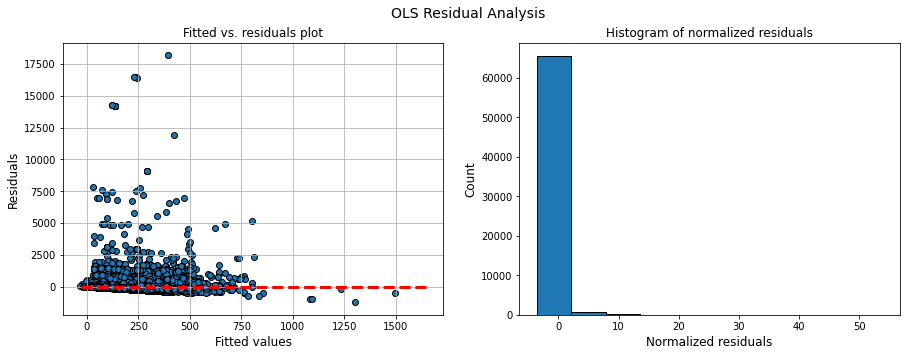

In [17]:
# OSL Residual Analysis
plt.figure(figsize=(15,5))

plt.subplot(121)

p=plt.scatter(x=model.fittedvalues,y=model.resid,edgecolor='k')
xmin=min(model.fittedvalues)
xmax = max(model.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=12)
plt.ylabel("Residuals",fontsize=12)
plt.title("Fitted vs. residuals plot",fontsize=12)
plt.grid(True)

plt.subplot(122)
plt.hist(model.resid_pearson,edgecolor='k')
plt.ylabel('Count',fontsize=12)
plt.xlabel('Normalized residuals',fontsize=12)
plt.title("Histogram of normalized residuals",fontsize=12)

plt.suptitle('OLS Residual Analysis',fontsize=14)
plt.show()

### Price Logarithm Transformation

In [18]:
df_reg['price_log'] = np.log(df_reg['price'])

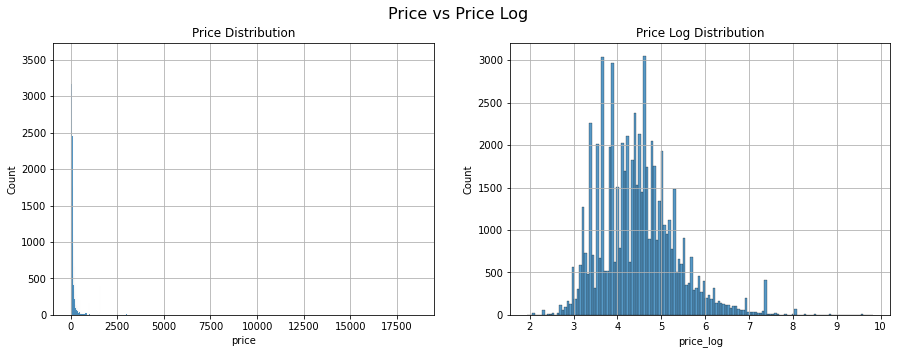

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.histplot(df_reg['price'])
plt.title('Price Distribution')
plt.grid()

plt.subplot(122)
sns.histplot(df_reg['price_log'])
plt.title('Price Log Distribution')
plt.grid()

plt.suptitle('Price vs Price Log', size=16)

plt.show()

In [20]:
# Droping price --> keep price log
df_reg.drop(columns='price', inplace=True)

#### Correlations with Price Log

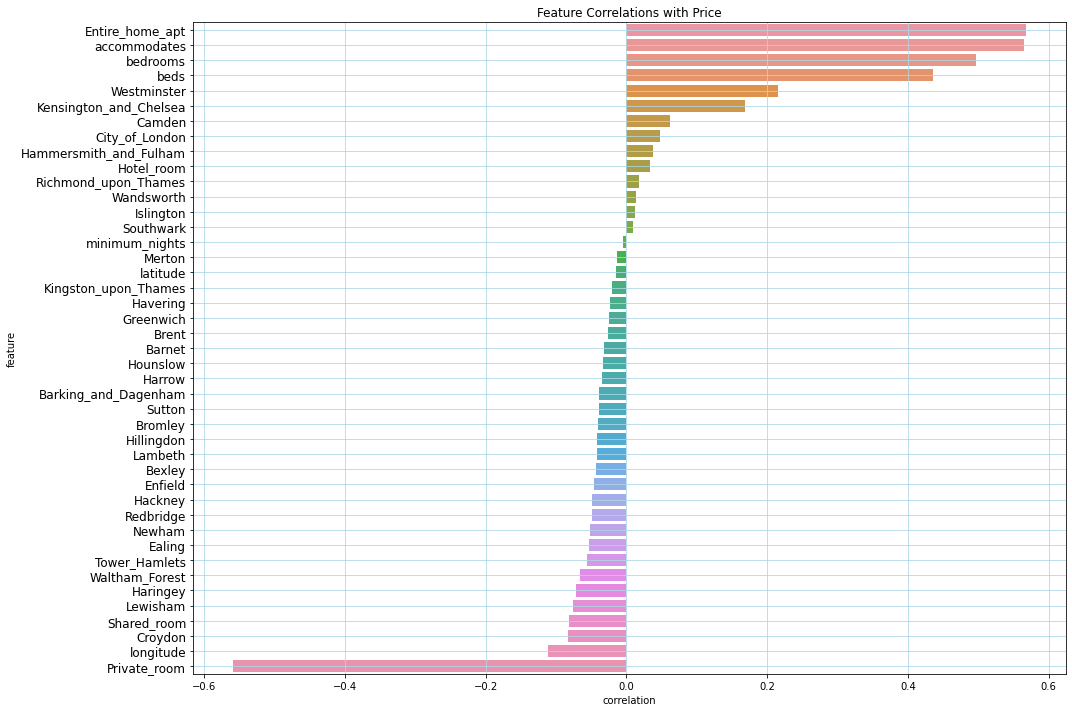

In [21]:
or_corr = pd.DataFrame(df_reg.corrwith(df_reg['price_log']).sort_values(ascending=False)).reset_index()
or_corr.columns = ['feature', 'correlation'] # rename columns
or_corr.drop(or_corr[or_corr['feature']=='price_log'].index,inplace=True)

plt.figure(figsize=(15,10))
sns.barplot(data=or_corr,x='correlation',y='feature')
plt.title('Feature Correlations with Price', size=12)
plt.yticks(size=12)
plt.grid(color='lightblue')
plt.tight_layout()
plt.show()

#### OLS Price Log

In [24]:
model_ols = smf.ols(formula = formula_from_cols(df_reg,'price_log'), data=df_reg).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     1589.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        19:48:01   Log-Likelihood:                -62091.
No. Observations:               66561   AIC:                         1.243e+05
Df Residuals:                   66519   BIC:                         1.246e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8.9710      6.435      1.394      0.163      -3.641      21.583
latitude                  -0.1500      0.160     -0.938      0.348      -0.464       0.164
longitude                  0.3944      0.099      3.998      0.000       0.201       0.588
accommodates               0.1235      0.003     47.839      0.000       0.118       0.129
bedrooms                   0.1592      0.005     31.668      0.000       0.149       0.169
beds                      -0.0228      0.004     -6.343      0.000      -0.030      -0.016
minimum_nights            -0.0002   7.89e-05     -2.520      0.012      -0.000   -4.41e-05
Entire_home_apt            2.5611      1.609      1.592      0.111      -0.592       5.714
Hotel_room                 2.7059      1.609      1.682      0.093      -0.448       5.859
Private_room               2.0134      1.609      1.251      0.211      -1.140       5.167
Shared_room                1.6906      1.609      1.051      0.293      -1.463       4.844
Barking_and_Dagenham       0.0241      0.207      0.116      0.907      -0.382       0.430
Barnet                     0.3174      0.209      1.515      0.130      -0.093       0.728
Bexley                    -0.0989      0.197     -0.502      0.616      -0.485       0.288
Brent                      0.3256      0.201      1.618      0.106      -0.069       0.720
Bromley                    0.0416      0.182      0.229      0.819      -0.315       0.398
Camden                     0.5458      0.200      2.728      0.006       0.154       0.938
City_of_London             0.7811      0.199      3.921      0.000       0.391       1.172
Croydon                   -0.0252      0.177     -0.142      0.887      -0.372       0.321
Ealing                     0.2759      0.196      1.409      0.159      -0.108       0.660
Enfield                    0.1083      0.218      0.498      0.619      -0.318       0.535
Greenwich                  0.2072      0.194      1.066      0.287      -0.174       0.588
Hackney                    0.2479      0.202      1.225      0.221      -0.149       0.645
Hammersmith_and_Fulham     0.4852      0.192      2.526      0.012       0.109       0.862
Haringey                   0.0890      0.209      0.426      0.670      -0.320       0.498
Harrow                     0.2715      0.209      1.298      0.194      -0.139       0.681
Havering                  -0.0153      0.215     -0.071      0.943      -0.436       0.406
Hillingdon                 0.2849      0.199      1.435      0.151      -0.104       0.674
Hounslow                   0.3086      0.190      1.623      0.105      -0.064       0.681
Islington                  0.4209      0.202      2.087      0.037       0.026       0.816
Kensington_and_Chelsea     0.7913      0.194      4.087      0.000       0.412  

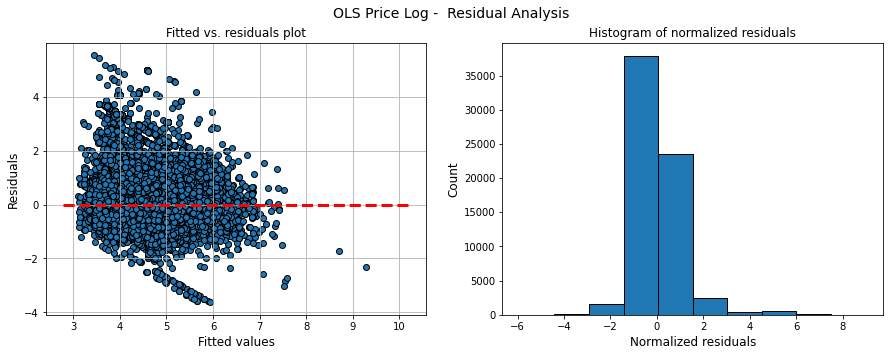

In [25]:
# OSL Residual Analysis
plt.figure(figsize=(15,5))

plt.subplot(121)

p=plt.scatter(x=model_ols.fittedvalues,y=model_ols.resid,edgecolor='k')
xmin=min(model_ols.fittedvalues)
xmax = max(model_ols.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=12)
plt.ylabel("Residuals",fontsize=12)
plt.title("Fitted vs. residuals plot",fontsize=12)
plt.grid(True)

plt.subplot(122)
plt.hist(model_ols.resid_pearson,edgecolor='k')
plt.ylabel('Count',fontsize=12)
plt.xlabel('Normalized residuals',fontsize=12)
plt.title("Histogram of normalized residuals",fontsize=12)

plt.suptitle('OLS Price Log -  Residual Analysis',fontsize=14)
plt.show()

In [26]:
import pickle

# Export pipeline as pickle file
with open("model_ols_price_log.pkl", "wb") as file:
    pickle.dump(model_ols, file )

#### Testing Different Models

In [27]:
# Initializing Models 
model_lg = LinearRegression()
model_knn = KNeighborsRegressor()
model_sgd = SGDRegressor()
model_xg = XGBRegressor()
model_rf = RandomForestRegressor()

# GridSearch Parameters
# Initiaze the hyperparameters for each model
param_lg = {}
param_lg['scaler'] = [StandardScaler(),MinMaxScaler(),RobustScaler()]
param_lg['model'] = [model_lg]

param_knn = {}
param_knn['scaler'] = [StandardScaler(),MinMaxScaler(),RobustScaler()]
param_knn['model__n_neighbors'] = [1,3,5,7,10,15]
param_knn['model'] = [model_knn]

param_sgd = {}
param_sgd['scaler'] = [StandardScaler(),MinMaxScaler(),RobustScaler()]
param_sgd['model__loss'] = ['squared_error','huber']
param_sgd['model__learning_rate'] = ['constant','optimal','invscaling']
param_sgd['model'] = [model_sgd]

param_xg={}
param_xg['model__booster'] = ['gbtree','gblinear']
param_xg['model__learning_rate'] = [0.3,0.1,0.001]
param_xg['model__max_depth'] = [2,4,6]
param_xg['model'] = [model_xg]

param_rf={}
param_rf['model__max_depth'] = [2,4,6]
param_rf['model__n_estimators'] = [5,10,20,50,100]
param_rf['model'] = [model_rf]


params = [param_lg,param_knn,param_sgd,param_xg,param_rf]

# Creating the pipe
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('model',model_xg)
])
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              gamma=None, gpu_id=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [28]:
%%time

X = df_reg.drop(columns='price_log')
y = df_reg['price_log']

# train-test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the grid search model
gs = GridSearchCV(pipe, params, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)

CPU times: user 33 s, sys: 2.91 s, total: 35.9 s
Wall time: 10min 9s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster='gbtree',
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     enable_categorical=False,
                                                     gamma=None, gpu_id=None,
                                                     importance_type=None,
                                                     interaction_constraints=None,
                                                     learning_rate=0.1,
                                                     max_delta_step=None,
                                                     max_depth=6,
                                                     min_chil...
                                                 reg_lambda=None,
                                                 scale_pos_weight=None,
                                                 subsample=None,
                                                 tree_method=None,
                                                 validate_parameters=None,
                                                 verbosity=None)],
                          'model__booster': ['gbtree', 'gblinear'],
                          'model__learning_rate': [0.3, 0.1, 0.001],
                          'model__max_depth': [2, 4, 6]},
                         {'model': [RandomForestRegressor()],
                          'model__max_depth': [2, 4, 6],
                          'model__n_estimators': [5, 10, 20, 50, 100]}],
             scoring='neg_mean_absolute_error')

In [29]:
gs.best_params_

{'model': XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None),
 'model__booster': 'gbtree',
 'model__learning_rate': 0.1,
 'model__max_depth': 6}

In [30]:
gs.best_score_

-0.3767808927085387

In [31]:
# Score
print(f'Score in Train: {gs.score(X_train,y_train)}')
print(f'Score in Test: {gs.score(X_test,y_test)}')

Score in Train: -0.3579508995396291
Score in Test: -0.3712454530424839


Scoring with Test data
R2 Score: 0.6275684674140418
RMSE: 0.5340843583914264
MAE: 0.3712454530424839
MAPE: 0.08401812875757833


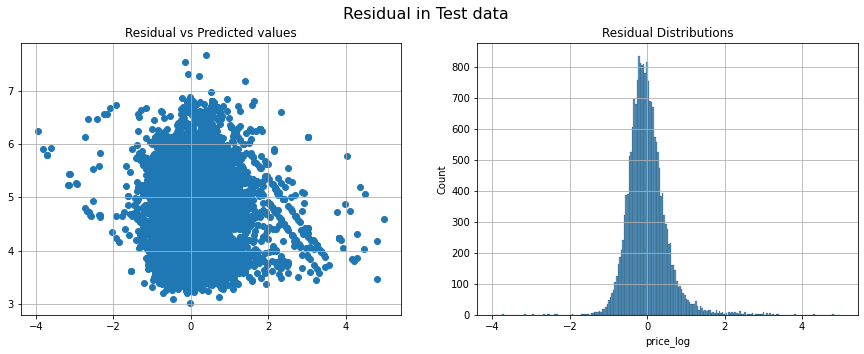

In [35]:
y_pred = gs.predict(X_test)
print('Scoring with Test data')

print(f'R2 Score: {r2_score(y_test,y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred,squared=False)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')

# Test set Residual Analysis
residuals = y_test - y_pred

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(residuals,y_pred)
plt.grid()
plt.title('Residual vs Predicted values')

plt.subplot(122)
sns.histplot(residuals)
plt.grid()
plt.title('Residual Distributions')

plt.suptitle('Residual in Test data', size=16)
plt.show()

#### XGBoost Regressor 

In [37]:
model_xg = XGBRegressor(booster='gbtree', learning_rate=0.1, max_depth=6)

model_xg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [38]:
# Score
print(f'Score in Train: {model_xg.score(X_train,y_train)}')
print(f'Score in Test: {model_xg.score(X_test,y_test)}')

Score in Train: 0.6504973560436841
Score in Test: 0.6291214520417063


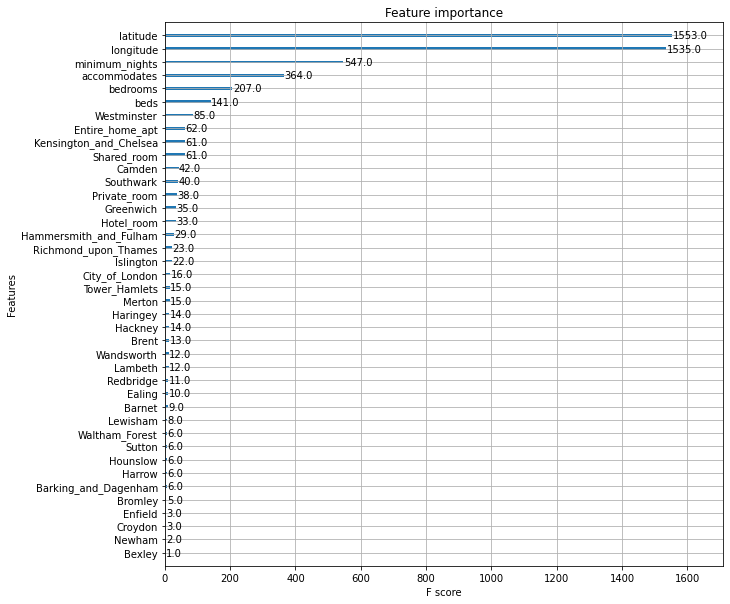

In [40]:
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (10, 10)
plot_importance(model_xg,importance_type='weight')

plt.show()

Scoring with Train data
R2 Score: 0.6504973560436841
RMSE: 0.5090348953623733
MAE: 0.35747029082572074
MAPE: 0.0811255359553868


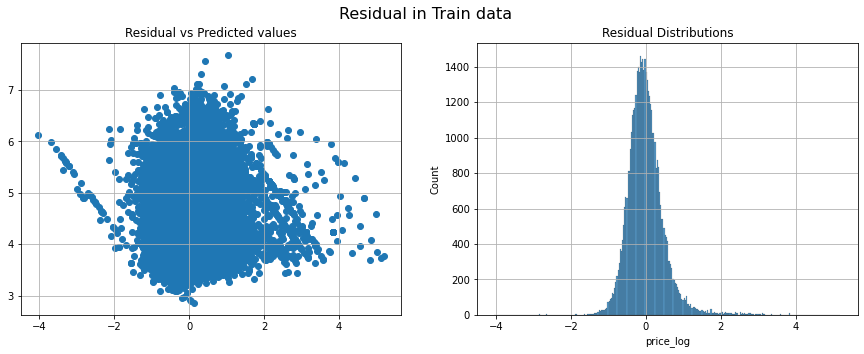

Scoring with Test data
R2 Score: 0.6291214520417063
RMSE: 0.5329696686054513
MAE: 0.37036664446281653
MAPE: 0.08383321071865057


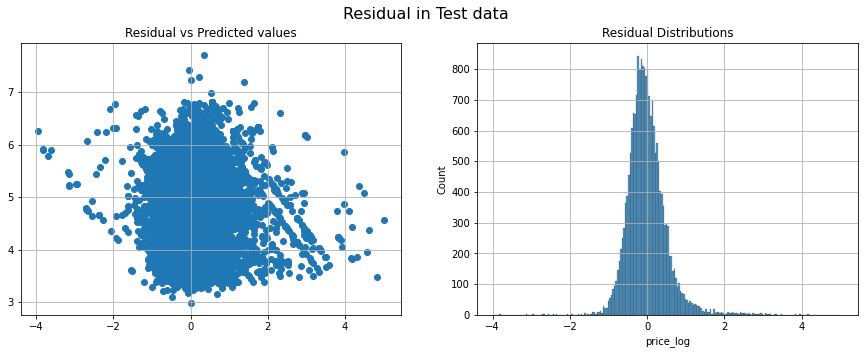

In [43]:
# Predict Train data
y_pred_train = model_xg.predict(X_train)

# Scoring
print('Scoring with Train data')
print(f'R2 Score: {r2_score(y_train,y_pred_train)}')
print(f'RMSE: {mean_squared_error(y_train, y_pred_train,squared=False)}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train)}')
print(f'MAPE: {mean_absolute_percentage_error(y_train, y_pred_train)}')

# Train set Residual Analysis
residuals_train = y_train - y_pred_train

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(residuals_train,y_pred_train)
plt.grid()
plt.title('Residual vs Predicted values')

plt.subplot(122)
sns.histplot(residuals_train)
plt.grid()
plt.title('Residual Distributions')

plt.suptitle('Residual in Train data', size=16)
plt.show()

# -----------------------------
# Predict Test Data
y_pred = model_xg.predict(X_test)

# Scoring
print('Scoring with Test data')
print(f'R2 Score: {r2_score(y_test,y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred,squared=False)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')

# Test set Residual Analysis
residuals = y_test - y_pred

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(residuals,y_pred)
plt.grid()
plt.title('Residual vs Predicted values')

plt.subplot(122)
sns.histplot(residuals)
plt.grid()
plt.title('Residual Distributions')

plt.suptitle('Residual in Test data', size=16)
plt.show()

In [63]:
# Export pipeline as pickle file
with open("model_xg_price_log.pkl", "wb") as file:
    pickle.dump(model_xg, file )

#### Random Forest with Top Features

In [45]:
col = [
    'latitude',
    'longitude',
    'accommodates',
    'bedrooms',
    'beds',
    'minimum_nights',
    'Entire_home_apt',
    'price_log'
]

df_final = df_reg[col].copy()
df_final.head(5)

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,Entire_home_apt,price_log
0,51.56861,-0.11270,2,1.0,1.758031,1,0.0,4.174387
1,51.48780,-0.16813,2,1.0,1.000000,3,1.0,4.317488
2,51.52195,-0.14094,6,3.0,3.000000,4,1.0,5.579730
3,51.47935,-0.19743,2,1.0,1.000000,3,0.0,5.010635
4,51.57438,-0.21081,2,1.0,1.758031,10,0.0,3.367296


In [46]:
%%time

X = df_final.drop(columns='price_log')
y = df_final['price_log']

# train-test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model
model_rf = RandomForestRegressor(criterion="absolute_error", n_jobs=-1)
model_rf.fit(X_train,y_train)

CPU times: user 1h 33min 13s, sys: 1min 6s, total: 1h 34min 19s
Wall time: 17min 58s


RandomForestRegressor(criterion='absolute_error', n_jobs=-1)

Scoring with Train data
R2 Score: 0.9452967796543827
RMSE: 0.20138576506625658
MAE: 0.13923059354340403
MAPE: 0.03188000758763138
Exponential MAE: 1.1493891111553918


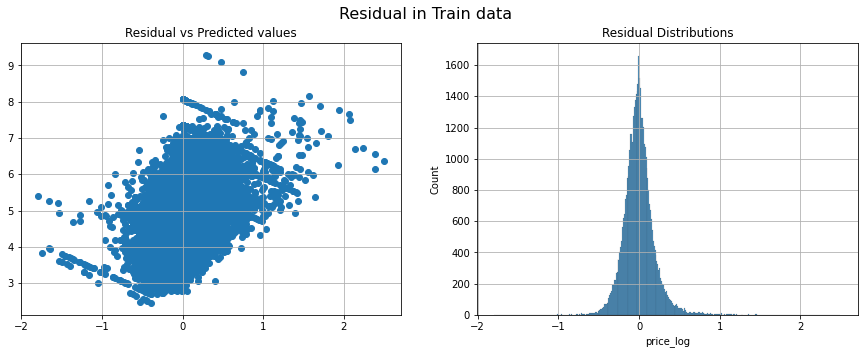

Scoring with Test data
R2 Score: 0.651902441557517
RMSE: 0.5163416111401633
MAE: 0.35857444787774334
MAPE: 0.08210979761659387
Exponential MAE: 1.4312875844849033


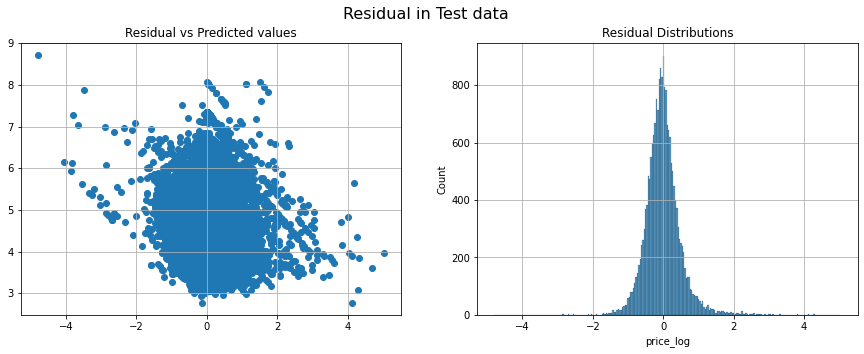

In [65]:
# Predict Train data
y_pred_train = model_rf.predict(X_train)

# Scoring
print('Scoring with Train data')
print(f'R2 Score: {r2_score(y_train,y_pred_train)}')
print(f'RMSE: {mean_squared_error(y_train, y_pred_train,squared=False)}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train)}')
print(f'MAPE: {mean_absolute_percentage_error(y_train, y_pred_train)}')
print(f'Exponential MAE: {np.exp(mean_absolute_error(y_train, y_pred_train))}')

# Train set Residual Analysis
residuals_train = y_train - y_pred_train

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(residuals_train,y_pred_train)
plt.grid()
plt.title('Residual vs Predicted values')

plt.subplot(122)
sns.histplot(residuals_train)
plt.grid()
plt.title('Residual Distributions')

plt.suptitle('Residual in Train data', size=16)
plt.show()

# -----------------------------
# Predict Test Data
y_pred = model_rf.predict(X_test)

# Scoring
print('Scoring with Test data')
print(f'R2 Score: {r2_score(y_test,y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred,squared=False)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Exponential MAE: {np.exp(mean_absolute_error(y_test, y_pred))}')

# Test set Residual Analysis
residuals = y_test - y_pred

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(residuals,y_pred)
plt.grid()
plt.title('Residual vs Predicted values')

plt.subplot(122)
sns.histplot(residuals)
plt.grid()
plt.title('Residual Distributions')

plt.suptitle('Residual in Test data', size=16)
plt.show()

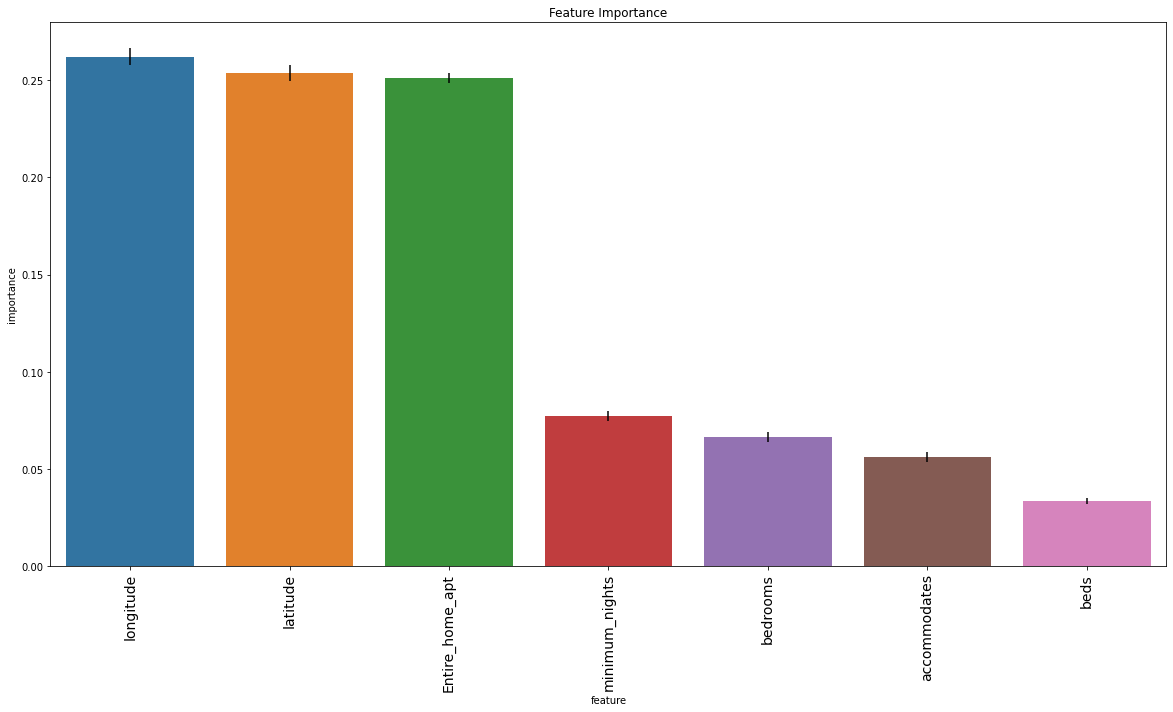

In [48]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
importances = model_rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

a=pd.DataFrame(forest_importances).reset_index()
a.columns = ['feature','importance']
a['std'] = std
a.sort_values(by='importance', ascending=False,inplace=True)


plt.figure(figsize=(20,10))
sns.barplot(data=a,y='importance',x='feature',yerr=a['std'])
plt.xticks(rotation=90,size=14)
plt.title('Feature Importance')
plt.show()

#### Final Model Pickle File

In [62]:
# Export pipeline as pickle file
with open("model_rf_price_log.pkl", "wb") as file:
    pickle.dump(model_rf, file )

In [60]:
np.exp(y_test[:3])

12858    50.0
14712    33.0
24178    35.0
Name: price_log, dtype: float64

In [61]:
np.exp(model_rf.predict(X_test[:3]))

array([50.52710186, 39.39307628, 34.47840057])